# Input Cell

In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import pyneb as pn
import pandas as pd
from scipy.interpolate import interp1d, LinearNDInterpolator
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
def get_continuum(self, tem, den, He1_H=0., He2_H=0., wl=np.array([3500, 3600, 3700, 3800, 3900]), 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True, HI_label='11_2'):
        """
        
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable.
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem.
            He1_H (float):  He+/H+ abundance. Default = 0.0
            He2_H (float): He++/H+ abundances.  Default = 0.0
            wl (np.array): Wavelengths Default = np.array([3500, 3600, 3700, 3800, 3900])
            cont_HI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeII (bool): using B. Ercolano 2006 data. Default: True
            cont_2p (bool): 2 photons, using D. Pequignot fit to Osterbrock. Default: True
            cont_ff (bool): from Storey & Hummer 1991. Default: True
            
            HI_label (str): HI label to normalize the continuum. If None, no normalization is done. Default: '11_2'
            
        Returns:
            The resulting continuum. Unit [A-1] if normalized, [erg/s.cm3/A] otherwise
        
        Exemple of use:
            C = pn.Continuum()
            wl = np.arange(3500, 4000, 1)
            cont = C.get_continuum(tem=1e4, den=1e2, He1_H=0.08, He2_H=0.02, wl=wl)
            plt.plot(wl, cont)
        """
        try:
            _ = (e for e in tem)
            T_iterable = True
            try:
                _ = (e for e in den)
            except:
                den = np.ones_like(tem) * den
            try:
                _ = (e for e in He1_H)
            except:
                He1_H = np.ones_like(tem) * He1_H
            try:
                _ = (e for e in He2_H)
            except:
                He2_H = np.ones_like(tem) * He2_H
            
        except TypeError:
            T_iterable = False
        if HI_label is None:
            norm = 1.0
        else:
            if self.HI is None:
                self.HI = pn.RecAtom('H',1)
            norm = self.HI.getEmissivity(tem, den, label = HI_label, product=False)
            
        if T_iterable:
            cont = np.array(list(map(lambda t, d, He1_H_1,He2_H_1 : self._get_continuum1(t, d, 
                                                                                  He1_H=He1_H_1, 
                                                                                  He2_H=He2_H_1, 
                                                                                  wl=wl, 
                                                                                  cont_HI=cont_HI, 
                                                                                  cont_HeI=cont_HeI, 
                                                                                  cont_HeII=cont_HeII, 
                                                                                  cont_2p=cont_2p, 
                                                                                  cont_ff=cont_ff), 
                                     tem, den, He1_H, He2_H))).T
            return cont.squeeze()/norm
        else:
            cont = self._get_continuum1(tem, den, He1_H=He1_H, He2_H=He2_H, wl=wl, 
                                        cont_HI=cont_HI, cont_HeI=cont_HeI, cont_HeII=cont_HeII, 
                                        cont_2p=cont_2p, cont_ff=cont_ff)
            return cont/norm

/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


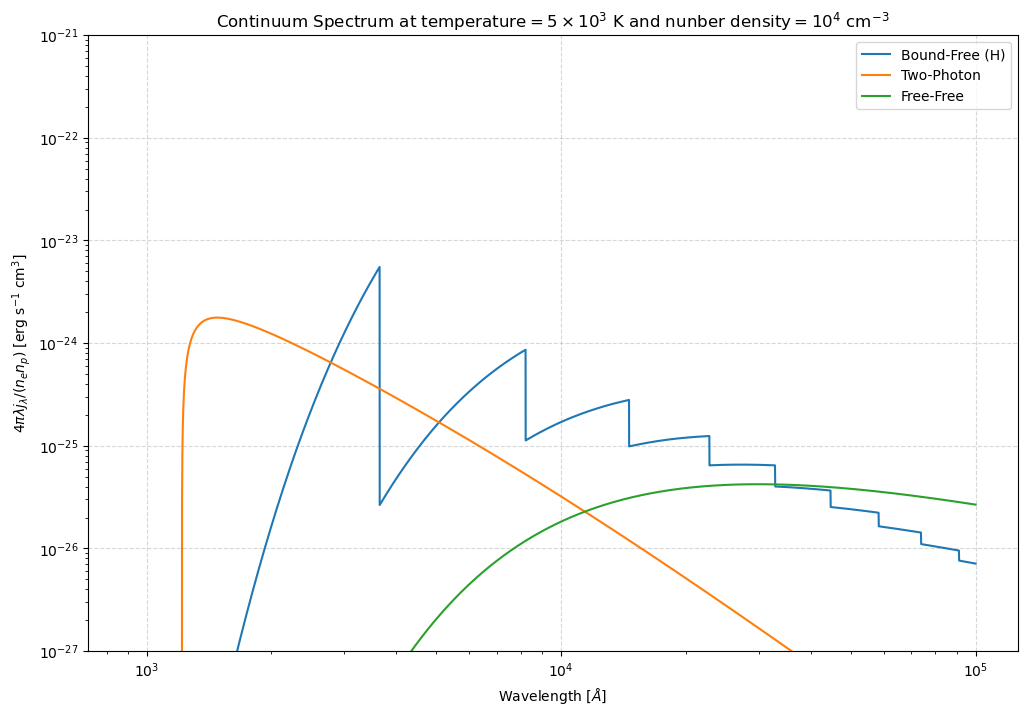

In [3]:
# initialize continuum calculator
C = pn.Continuum()
temp = 5e3    # gas temperature [K]
dense = 1e4   # number density [cm⁻³]

# create log-spaced wavelength array
wl = np.logspace(np.log10(912), np.log10(1e5), 8000)

# compute continuum emission components
contH = C.get_continuum(
    tem = temp, den = dense, wl = wl, HI_label = None,
    cont_HI = True, cont_HeI = False, cont_HeII = False,  # bound-free emission only
    cont_2p = False, cont_ff = False
)

cont2p = C.get_continuum(
    tem = temp, den = dense, wl = wl, HI_label = None,
    cont_HI = False, cont_HeI = False, cont_HeII = False,  # two-photon emission only
    cont_2p = True, cont_ff = False
)

contff = C.get_continuum(
    tem = temp, den = dense, wl = wl, HI_label = None,
    cont_HI = False, cont_HeI = False, cont_HeII = False,  # free-free emission only
    cont_2p = False, cont_ff = True
)

# plot continuum components
plt.figure(figsize = (12, 8))
plt.plot(wl, contH * wl, label = "Bound-Free (H)")
plt.plot(wl, cont2p * wl, label = "Two-Photon")
plt.plot(wl, contff * wl, label = "Free-Free")
plt.legend()
plt.ylim(1e-27, 1e-21)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"$4\pi\lambda j_\lambda / (n_e n_p)$ [erg s$^{-1}$ cm$^3$]")
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.title(r"Continuum Spectrum at $\text{temperature} = 5\times10^3$ K and $\text{nunber density} = 10^4$ cm$^{-3}$")
plt.show()

# Preparing data

In [5]:
# define cell fields to load from simulation
cell_fields = [
    "Density",              # gas density
    "x-velocity",           # velocity component along x-axis
    "y-velocity",           # velocity component along y-axis
    "z-velocity",           # velocity component along z-axis
    "Pressure",             # thermal pressure
    "Metallicity",          # metal mass fraction
    "dark_matter_density",  # dark matter density (optional)
    "xHI",                  # neutral hydrogen fraction
    "xHII",                 # ionized hydrogen fraction
    "xHeII",                # singly-ionized helium fraction
    "xHeIII",               # doubly-ionized helium fraction
]

# define extra particle fields for star particles
epf = [
    ("particle_family", "b"),         # particle type identifier
    ("particle_tag", "b"),            # unique particle ID tag
    ("particle_birth_epoch", "d"),    # formation epoch
    ("particle_metallicity", "d"),    # particle metal mass fraction
]

# load dataset based on simulation output location
f1 = '/Users/lamoreau/python/ASpec/SimulationFiles/output_00273'  # path to simulation snapshot
ds = yt.load(f1, 
             fields = cell_fields, 
             extra_particle_fields = epf,
             default_species_fields = "ionized")

# create a data container for global analysis
ad = ds.all_data()  # includes all fluid grid cells and all particles (if present)

yt : [WARNING  ] 2025-10-20 13:32:55,892 `namelist.txt` file found but missing package f90nml to read it:
Traceback (most recent call last):
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/frontends/ramses/data_structures.py", line 1146, in read_namelist
    nml = f90nml.read(f)
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/utilities/on_demand_imports.py", line 39, in __call__
    raise self.error
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/utilities/on_demand_imports.py", line 77, in inner
    return func(self)
  File "/Users/lamoreau/anaconda3/envs/pynebenv/lib/python3.10/site-packages/yt/utilities/on_demand_imports.py", line 420, in read
    from f90nml import read
ModuleNotFoundError: No module named 'f90nml'
Something went wrong while trying to lazy-import f90nml. Please make sure that f90nml is properly installed.
If the problem persists, please file an issue at https://github.co

In [6]:
# extract particle positions from the dataset
x_pos = np.array(ad["star", "particle_position_x"]) # position component along x-axis
y_pos = np.array(ad["star", "particle_position_y"]) # position component along y-axis
z_pos = np.array(ad["star", "particle_position_z"]) # position component along z-axis

# calculate mean position of those particles to find where the center is
x_center = np.mean(x_pos)  # x-center
y_center = np.mean(y_pos)  # y-center
z_center = np.mean(z_pos)  # z-center

# recenter positions relative to the center by setting center to be at 0
x_pos = x_pos - x_center  # shifted x-positions
y_pos = y_pos - y_center  # shifted y-positions
z_pos = z_pos - z_center  # shifted z-positions

# store the original center before shifting
ctr_at_code = np.array([x_center, y_center, z_center])  # center in code units

yt : [INFO     ] 2025-10-20 13:33:50,882 Identified   384/  384 intersecting domains (  385 through hilbert key indexing)


In [7]:
# define plot width for visualization
plt_wdth = 400  # total plot width in parsecs

In [8]:
ds.fields

yt : [INFO     ] 2025-10-20 13:34:48,634 Projection completed
yt : [INFO     ] 2025-10-20 13:34:48,637 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-10-20 13:34:48,637 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-10-20 13:34:48,640 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-10-20 13:34:48,640 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-10-20 13:34:48,643 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800


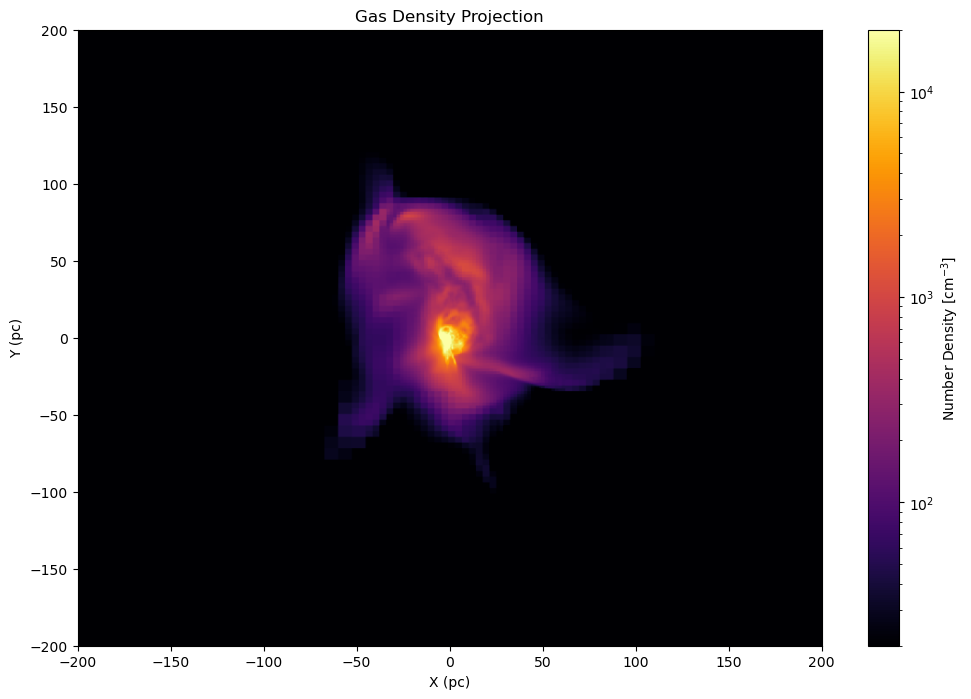

In [9]:
# generate the gas number density projection using yt
p = yt.ProjectionPlot(
    ds,                              # loaded dataset
    "z",                             # projection axis (along z-direction)
    ("gas", "number_density"),       # field to visualize (gas number density)
    width = (plt_wdth, "pc"),         # plot width (in parsecs)
    weight_field = ("gas", "number_density"),  # density-weighted projection
    center = ctr_at_code              # center position (in code units)
)

# extract pixel data for matplotlib plotting
p_frb = p.frb                                      # fixed-resolution buffer (FRB) object
p_img = np.array(p_frb["gas", "number_density"])    # convert field to NumPy array

# prepare star particle data
star_bins = 2000                                    # number of bins for particle distribution analysis
star_mass = np.ones_like(x_pos) * 10                # placeholder particle masses (10 units each)
pop2_xyz = np.array(ds.arr(np.vstack([x_pos, y_pos, z_pos]), "code_length").to("pc")).T  # particle positions in parsecs

# configure plot appearance
extent_dens = [-plt_wdth/2, plt_wdth/2, -plt_wdth/2, plt_wdth/2]  # plot boundaries [pc]
gas_range = (20, 2e4)                                             # density range for color mapping
norm_gas = LogNorm(vmin = gas_range[0], vmax = gas_range[1])      # logarithmic color scaling

# create the figure
plt.figure(figsize = (12, 8))
plt.imshow(
    p_img,
    norm = norm_gas,
    extent = extent_dens,
    origin = "lower",
    aspect = "auto",
    cmap = "inferno"
)
plt.colorbar(label = r"Number Density [cm$^{-3}$]")

# finalize plot
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("Gas Density Projection")
plt.xlim(-plt_wdth/2, plt_wdth/2)
plt.ylim(-plt_wdth/2, plt_wdth/2)
plt.show()

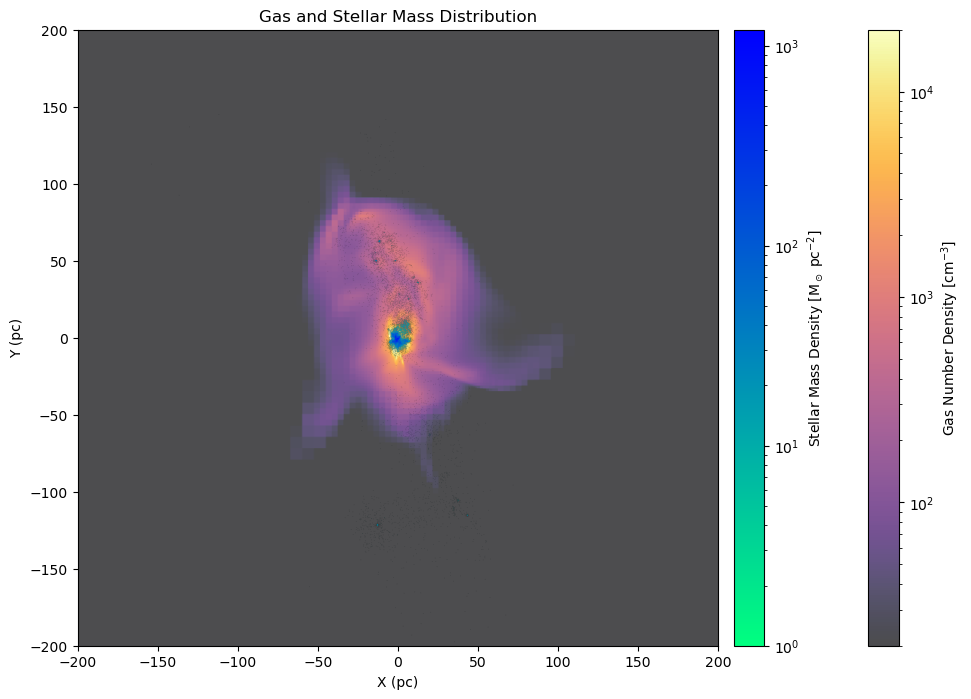

In [10]:
# calculate 2D stellar mass density histogram
stellar_mass_dens, _, _ = np.histogram2d(
    pop2_xyz[:, 0],                   # x-positions (pc)
    pop2_xyz[:, 1],                   # y-positions (pc)
    bins = star_bins,                 # number of bins (resolution)
    weights = star_mass,              # mass-weighted particles
    range = [                         # histogram range (match gas plot extent)
        [-plt_wdth/2, plt_wdth/2],
        [-plt_wdth/2, plt_wdth/2]
    ],
)
stellar_mass_dens = stellar_mass_dens.T  # transpose for correct imshow orientation

# filter sparse bins (remove noise)
stellar_mass_dens = np.where(stellar_mass_dens <= 1, 0, stellar_mass_dens)

# configure plot appearance
stellar_range = (1, 1200)                      # stellar mass density range
norm_star = LogNorm(vmin = stellar_range[0], vmax = stellar_range[1])  # logarithmic color scaling

# initialize figure
fig, ax = plt.subplots(figsize = (12, 8))

# plot gas number density
img1 = ax.imshow(
    p_img,                             # precomputed gas density array
    norm = norm_gas,                   # logarithmic scaling
    extent = extent_dens,
    origin = "lower",
    aspect = "auto",
    cmap = "inferno",                  # hot colormap for gas
    alpha = 0.7                          # fully opaque
)
cbar1 = fig.colorbar(img1, ax = ax, orientation = "vertical", pad = 0.02)
cbar1.set_label(r"Gas Number Density [cm$^{-3}$]")

# create transparency mask (set alpha = 0 where stellar mass is low)
alpha_star = np.where(stellar_mass_dens <= 1, 0.0, 1.0)

# overlay stellar mass density
img2 = ax.imshow(
    stellar_mass_dens,
    norm = norm_star,                  # logarithmic scaling
    extent = extent_dens,
    origin = "lower",
    aspect = "auto",
    cmap = "winter_r",                 # cool colormap for stars
    alpha = alpha_star                 # mask low-density bins
)
cbar2 = fig.colorbar(img2, ax = ax, orientation = "vertical", pad = 0.02)
cbar2.set_label("Stellar Mass Density [M$_\odot$ pc$^{-2}$]")

# plot formatting
ax.set(
    xlabel = "X (pc)",
    ylabel = "Y (pc)",
    title = "Gas and Stellar Mass Distribution",
    xlim = (-plt_wdth/2, plt_wdth/2),
    ylim = (-plt_wdth/2, plt_wdth/2)
)
plt.show()

In [11]:
# extract relevant fields
xHII = p_frb["ramses", "xHII"].value.flatten()           # ionized hydrogen fraction
nH_tot = p_frb["gas", "H_nuclei_density"].value.flatten() # total hydrogen nuclei density
n_p_yt = p_frb["gas", "H_p1_number_density"].value.flatten() # native proton density from yt

# calculate proton density manually
n_p_calc = xHII * nH_tot

# compare calculated vs native
p_diff = np.abs(n_p_calc - n_p_yt)

# print proton density results
print("\nProton density comparison:")
print(f"Calculated proton density: {n_p_calc[0]:.3e} cm$^{{-3}}$")
print(f"Native proton density (H_p1_number_density): {n_p_yt[0]:.3e} cm$^{{-3}}$")
print(f"Absolute difference: {p_diff[0]:.3e} cm$^{{-3}}$")

# electron Density Calculation
# extract helium ionization fractions
xHeII = p_frb["ramses", "xHeII"].value.flatten()  # singly-ionized helium fraction
xHeIII = p_frb["ramses", "xHeIII"].value.flatten() # doubly-ionized helium fraction

# primordial helium-to-hydrogen number ratio
nHe_nH_ratio = 0.1

# calculate electron density manually
n_e_calc = nH_tot * (xHII + nHe_nH_ratio * (xHeII + 2 * xHeIII))

# native yt electron density
n_e_yt = p_frb["gas", "El_number_density"].value.flatten()

# compare calculated vs native
e_diff = np.abs(n_e_calc - n_e_yt)
# print electron density results
print("\nElectron density comparison:")
print(f"Calculated electron density: {n_e_calc[0]:.3e} cm$^{{-3}}$")
print(f"Native electron density (El_number_density): {n_e_yt[0]:.3e} cm$^{{-3}}$")
print(f"Absolute difference: {e_diff[0]:.3e} cm$^{{-3}}$")

yt : [INFO     ] 2025-10-20 13:36:37,562 Making a fixed resolution buffer of (('ramses', 'xHII')) 800 by 800
yt : [INFO     ] 2025-10-20 13:36:45,018 Projection completed
yt : [INFO     ] 2025-10-20 13:36:45,083 Making a fixed resolution buffer of (('gas', 'H_nuclei_density')) 800 by 800
yt : [INFO     ] 2025-10-20 13:36:51,276 Projection completed
yt : [INFO     ] 2025-10-20 13:36:51,351 Making a fixed resolution buffer of (('gas', 'H_p1_number_density')) 800 by 800
yt : [INFO     ] 2025-10-20 13:36:57,816 Projection completed
yt : [INFO     ] 2025-10-20 13:36:57,922 Making a fixed resolution buffer of (('ramses', 'xHeII')) 800 by 800



Proton density comparison:
Calculated proton density: 3.637e-04 cm$^{-3}$
Native proton density (H_p1_number_density): 1.057e-02 cm$^{-3}$
Absolute difference: 1.021e-02 cm$^{-3}$


yt : [INFO     ] 2025-10-20 13:37:04,904 Projection completed
yt : [INFO     ] 2025-10-20 13:37:04,991 Making a fixed resolution buffer of (('ramses', 'xHeIII')) 800 by 800
yt : [INFO     ] 2025-10-20 13:37:10,618 Projection completed
yt : [INFO     ] 2025-10-20 13:37:10,690 Making a fixed resolution buffer of (('gas', 'El_number_density')) 800 by 800
yt : [INFO     ] 2025-10-20 13:37:16,169 Projection completed



Electron density comparison:
Calculated electron density: 5.196e-04 cm$^{-3}$
Native electron density (El_number_density): 1.225e-02 cm$^{-3}$
Absolute difference: 1.173e-02 cm$^{-3}$


In [ ]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
from Fitser import searcher



def compute_average_flux_grid(temperature, density, wl,
                              filter_file = "your_file_name.txt",
                              z = 10):
    """
    Compute average specific fluxes for bound-free, two-photon, and free-free
    continuum components across a grid of temperatures and densities,
    through a JWST NIRCam filter corrected for redshift.

    Parameters
    ----------
    temperature : array-like
        Temperatures [K] at which to compute continuum fluxes.
    density : array-like
        Number densities [cm^-3] at which to compute continuum fluxes.
    wl : array-like
        Wavelength grid [Angstroms] for continuum calculation.
    filter_file : str
        Path to the JWST filter transmission file (first column: wavelength [microns],
        second column: transmission).
    z : float
        Redshift to apply to the filter wavelength grid.

    Returns
    -------
    df_results : pandas.DataFrame
        DataFrame containing average specific fluxes for each component at each
        temperature and density.
    """
    
    # join directory and filename
    filter_files = searcher("/Users/lamoreau/python/ASpec", "NIRSpecfil")

    # load and prepare JWST filter data
    F200W = filter_files[filter_file]
    df_F200W = F200W.to_pandas()
    wavelength = df_F200W["WAVELENGTH"]* 1e4 / (1 + z)  #_F200W_shifted #* 1e4 / (1 + z)
    output_F200W = df_F200W["THROUGHPUT"]

    # initialize storage
    results = []

    # iterate over parameter grid
    for tem in temperature:
        for den in density:
            # calculate continuum components
            contH = C.get_continuum(tem = tem, den = den, wl = wl, HI_label = None,
                                    cont_HI = True, cont_HeI = True, cont_HeII = True,
                                    cont_2p = False, cont_ff = False)
            cont2p = C.get_continuum(tem = tem, den = den, wl = wl, HI_label = None,
                                     cont_HI = False, cont_HeI = False, cont_HeII = False,
                                     cont_2p = True, cont_ff = False)
            contff = C.get_continuum(tem = tem, den = den, wl = wl, HI_label = None,
                                     cont_HI = False, cont_HeI = False, cont_HeII = False,
                                     cont_2p = False, cont_ff = True)

            # interpolate onto filter grid
            tolerance = 1e-10
            mask = (wl >= wavelength.min() - tolerance) & \
                   (wl <= wavelength.max() + tolerance) #_F200W_shifted #applies to both wavelengths
            
            print("Model wl range:", wl.min(), "to", wl.max())
            print("Filter wl range:", wavelength.min(), "to", wavelength.max())
            print("Overlap mask sum:", np.sum(mask))

            fluxH_interp = interp1d(wl[mask], contH[mask] * wl[mask], kind = "linear", fill_value = "extrapolate")
            flux2p_interp = interp1d(wl[mask], cont2p[mask] * wl[mask], kind = "linear", fill_value = "extrapolate")
            fluxff_interp = interp1d(wl[mask], contff[mask] * wl[mask], kind = "linear", fill_value = "extrapolate")

            # apply filter transmission
            resultH = fluxH_interp(wavelength) * output_F200W #_F200W_shifted
            result2p = flux2p_interp(wavelength) * output_F200W #_F200W_shifted
            resultff = fluxff_interp(wavelength) * output_F200W #_F200W_shifted

            # integrate and normalize
            integralH = np.trapz(resultH, wavelength) #_F200W_shifted
            integral2p = np.trapz(result2p, wavelength)
            integralff = np.trapz(resultff, wavelength)
            integral_filter = np.trapz(output_F200W * wavelength, wavelength)

            flux_avg_H = integralH / integral_filter
            flux_avg_2p = integral2p / integral_filter
            flux_avg_ff = integralff / integral_filter

            # store results
            results.append({
                "Temperature": tem,
                "Density": den,
                "Average Specific Flux ContH": flux_avg_H,
                "Average Specific Flux Cont2p": flux_avg_2p,
                "Average Specific Flux Contff": flux_avg_ff
            })

    df_results = pd.DataFrame(results)
    return df_results

In [38]:
# define temperature and density
temperatures = [1e3, 1e5]           # K
densities = [1e-4, 1e6]                 # cm^-3
wavelengths = np.linspace(912, 1e5, 8000)  # Angstroms
z = 10

# compute average fluxes
df_results = compute_average_flux_grid(
    temperature = temperatures, 
    density = densities, 
    wl = wavelengths, 
    filter_file = "f110w",
    z = z
    )

print(df_results.head())

Found directory: /Users/lamoreau/python/ASpec/JWST_FITS_Calibration/NIRSpecfil
Found 7 files:
Model wl range: 912.0 to 100000.0
Filter wl range: 0.3503279983997345 to 3.4000000953674316
Overlap mask sum: 0


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [ ]:
# extract data from DataFrame
temperature = df_results['Temperature'].values  # temperatures [K]
density = df_results['Density'].values          # number densities [cm^{-3}]
flux_avg_contH = df_results['Average Specific Flux ContH'].values  # bound-free continuum flux averages
flux_avg_cont2p = df_results['Average Specific Flux Cont2p'].values  # two-photon continuum flux averages
flux_avg_contff = df_results['Average Specific Flux Contff'].values  # free-free continuum flux averages

# prepare interpolation points
points = np.column_stack((temperature, density))  # combine temperature and density into (x, y) points

# set up interpolators for each continuum component
interp_func_contH = LinearNDInterpolator(points, flux_avg_contH)   # bound-free continuum interpolation
interp_func_cont2p = LinearNDInterpolator(points, flux_avg_cont2p) # two-photon continuum interpolation
interp_func_contff = LinearNDInterpolator(points, flux_avg_contff) # free-free continuum interpolation

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices